<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dependencies

In [1]:
!python3 -m pip install --upgrade pip
!python3 -m pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
			  torch \
              torchvision \
			  pycocotools \
			  pandas \
			  seaborn \
              torchviz -U && echo "Dependencies installation complete."

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:0101
  Attempting uninstall: pip
    Found existing installation: pip 22.3
    Uninstalling pip-22.3:
      Successfully uninstalled pip-22.3
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for dataclasses-json from https://files.pythonhosted.org/packages/13/75/82ce74880711ced796fd5a32e4d40c5a32dbea3f1c5e219a8b0544b7bd8c/dataclasses_json-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for supervision from https://files.pythonhosted.org/packages/38/31/19d39cde7723206ecc1e054d16c792204a76ab884fefa656ea297b26af9e/supervision-0.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for wandb from https://files.pythonhosted.org/packa

## WandB login

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [1]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 4

In [2]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

In [3]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from typing import Tuple, List
from PIL import Image
from collections import defaultdict as DD

import torchvision.transforms as transforms
import torchvision.transforms.functional as fun
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import cv2

import os

class CocoSegmentationDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 annotation_file: str,
                 do_transform: bool = True,
                 common_size: Tuple[int, int] = (512, 512),
                ):
        self.root_dir = root_dir
        self.common_size = common_size
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.category_ids = self.coco.getCatIds()
        self.num_categories = len(self.category_ids)

        if do_transform:
            self.transform = transforms.Compose([
                transforms.Resize(self.common_size),
                transforms.ToTensor(),
            ])
        else:
            self.transform = None

        self.normalize = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.coco.getImgIds())

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        annotations = self.coco.loadAnns(ann_ids)

        image = Image.open(image_path).convert("RGB")

        masks = np.zeros((self.num_categories, *self.common_size), dtype=np.float32)
        for ann in annotations:
            masks_buf = np.zeros((self.num_categories, *self.common_size), dtype=np.float32)
            cat_id = ann["category_id"]
            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.common_size, interpolation=cv2.INTER_NEAREST)
            masks_buf[cat_id - 1, :, :] = mask

            masks = np.maximum(masks_buf, masks)

        masks = torch.from_numpy(masks)

        if self.transform is not None:
            image = self.transform(image)

        # image = self.normalize(image/255.0) # very important because teaching it is better or something, thanks ArXiV

        return image / 255, masks

dataset = CocoSegmentationDataset(root_dir="dataset/train/",
                                  annotation_file="dataset/train/_annotations.coco.json")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


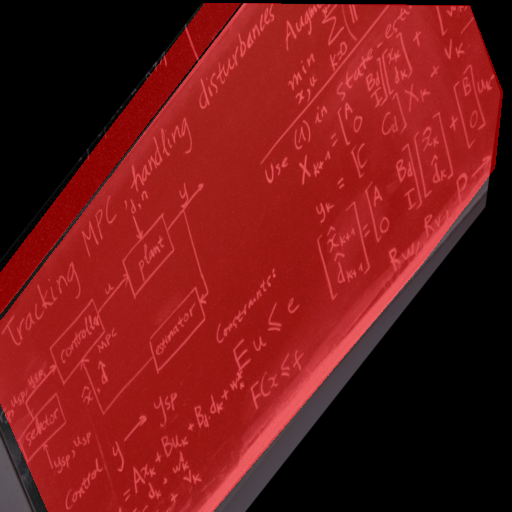

In [4]:
for batch in dataloader:
    imgs, labels = batch
    print(f"{imgs[0].shape} {labels[0].shape}")
    #display(tensor_to_pil(imgs[0] * 255))
    #display(tensor_to_pil(masks[0] * 40))
    display(tensor_to_pil(imgs[0]*100 + labels[0]*120))
    break

## FeynMAN Model Definition

In [5]:
import torch.nn as nn
import torchvision.models as models

class FeynMAN(nn.Module):
    def __init__(self, num_classes: int = 3):
        super(__class__, self).__init__()

        self.backbone = models.segmentation.fcn_resnet50(pretrained=False, num_classes=num_classes)  # untrained FCN_ResNet50

    def forward(self, x):
        return self.backbone(x)

# Training

In [17]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataloader: DataLoader,
    epochs: int = EPOCHS,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # Watch the model for cool weights & biases
    wandb.watch(model)

    # Loss function and optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()

    # Convert model to "device space"
    model = model.to(device)

    # Start training
    model.train()
    print("BEGIN TRAINING!")

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)["out"]
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            wandb.log({"loss": loss})

            print(
                f" # Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

            del inputs, labels

        wandb.log({"running_loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [8]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# start a new wandb run to track this script
wandb.init(
	# set the wandb project where this run will be logged
	project="feynman_0",

	# track hyperparameters and run metadata
	config={
	"learning_rate": LEARNING_RATE,
	"epochs": EPOCHS,
	"batch_size": BATCH_SIZE,
	"architecture": "FeynMAN fcn_resnet50",
	"dataset": "feynman_v9i",
	}
)

/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Start training loop

#### Train the model

In [9]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
train_model(model, dataloader=dataloader, device=device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!
BEGIN TRAINING!
Running batch:  0
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [1/52] - Loss: 0.8097
Running batch:  1
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [2/52] - Loss: 0.3849
Running batch:  2
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [3/52] - Loss: 0.4984
Running batch:  3
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [4/52] - Loss: 0.5242
Running batch:  4
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [5/52] - Loss: 0.6169
Running batch:  5
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [6/52] - Loss: 0.6347
Running batch:  6
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [7/52] - Loss: 0

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
running_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00044
running_loss,0.04408


In [11]:
torch.save(model, "models/feynman.pth")

## Test the model

In [6]:
import torch

model = torch.load("models/feynman.pth")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [32]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
cpu_device = torch.device("cpu")

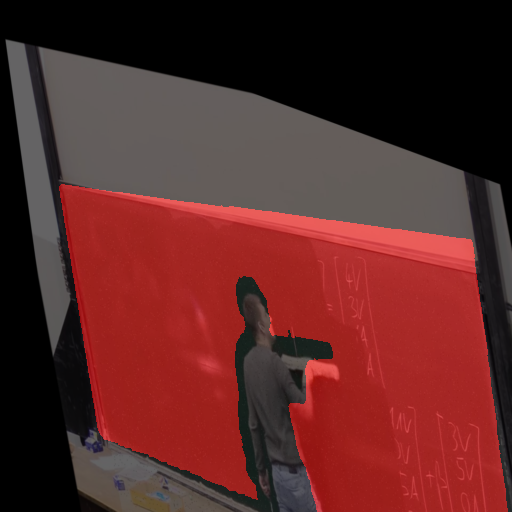

VS
tensor([[[[ 0.3348,  0.3348,  0.3348,  ...,  0.8847,  0.8847,  0.8847],
          [ 0.3348,  0.3348,  0.3348,  ...,  0.8847,  0.8847,  0.8847],
          [ 0.3348,  0.3348,  0.3348,  ...,  0.8847,  0.8847,  0.8847],
          ...,
          [-3.1718, -3.1718, -3.1718,  ...,  6.0079,  6.0079,  6.0079],
          [-3.1718, -3.1718, -3.1718,  ...,  6.0079,  6.0079,  6.0079],
          [-3.1718, -3.1718, -3.1718,  ...,  6.0079,  6.0079,  6.0079]],

         [[ 2.0091,  2.0091,  2.0091,  ...,  1.6903,  1.6903,  1.6903],
          [ 2.0091,  2.0091,  2.0091,  ...,  1.6903,  1.6903,  1.6903],
          [ 2.0091,  2.0091,  2.0091,  ...,  1.6903,  1.6903,  1.6903],
          ...,
          [ 6.7922,  6.7922,  6.7922,  ..., -2.2277, -2.2277, -2.2277],
          [ 6.7922,  6.7922,  6.7922,  ..., -2.2277, -2.2277, -2.2277],
          [ 6.7922,  6.7922,  6.7922,  ..., -2.2277, -2.2277, -2.2277]],

         [[-2.7454, -2.7454, -2.7454,  ..., -2.5728, -2.5728, -2.5728],
          [-2.7454, -2.7454

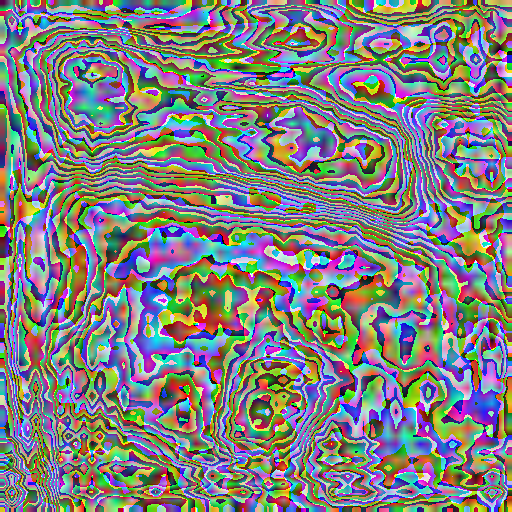

In [60]:
model = model.to(device)

img, label = dataset[14]
display(tensor_to_pil(img*100 + label*120))

print("VS")

img = img.to(device)
outputs = model(img.unsqueeze(0))
result = outputs["out"].to(cpu_device)

print(result, result.shape)
pic = tensor_to_pil(result.squeeze(0))
print(type(pic), pic)
display(pic)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0013, 0.0013, 0.0015],
         [0.0000, 0.0000, 0.0000,  ..., 0.0013, 0.0014, 0.0015],
         [0.0000, 0.0000, 0.0000,  ..., 0.0014, 0.0015, 0.0014]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

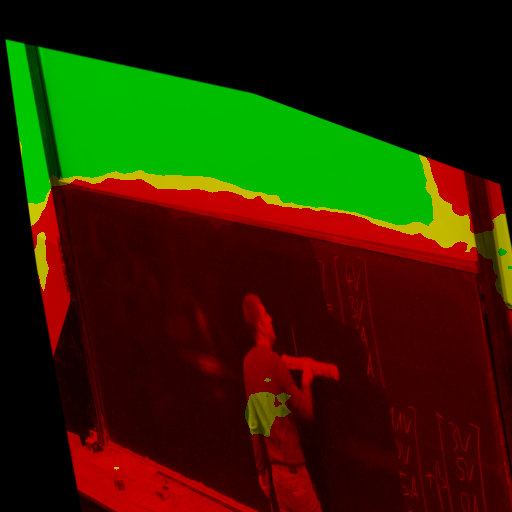

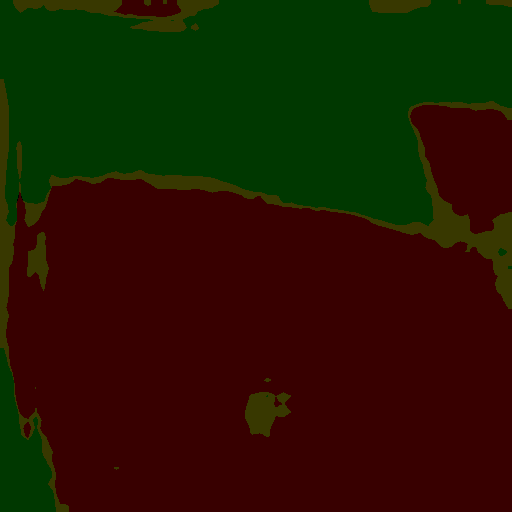

In [61]:
test = result.squeeze(0).to(cpu_device)
img = img.to(cpu_device)

bin_mask = test > 0.6
# print(bin_mask)

sk = img * bin_mask

print(sk)

result_img = tensor_to_pil(sk*200)
mask_img = tensor_to_pil(bin_mask.float() * 200)
display(result_img)
display(mask_img)